In [16]:
import numpy as np
import pandas as pd


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [32]:
data = pd.read_csv('AirlineTweets.csv')
data = data.sample(frac=1).reset_index(drop=True)
data = data[['airline_sentiment','text']]
print(data.shape)

data.head()


(14640, 2)


,airline_sentiment,text
0,negative,"@United what the...? I go into the ""all airlin..."
1,negative,@USAirways literally the worst flying experien...
2,negative,@AmericanAir The pilot told us they would rele...
3,negative,@USAirways very embarrassing.
4,negative,@SouthwestAir wifi stays connected about the l...


<AxesSubplot:>

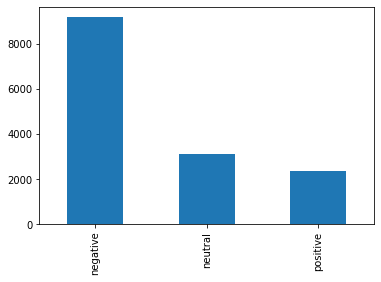

In [4]:
data['airline_sentiment'].value_counts().sort_index().plot.bar()

In [34]:
# Data Pre-Processing

punctuation = '!"#$%&\'()*+,-./:;<=>?[\\]^_`{|}~'

def remove_handle(text, pattern):
    r = re.findall(pattern,text)
    for word in r:
        text = re.sub(word, '', text)
    return text
stop_words = set(stopwords.words('english'))

data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = np.vectorize(remove_handle)(data['text'],'@[\w]*')
data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
data['clean_text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
data.head()
  

,airline_sentiment,text,clean_text
0,negative,what the i go into the all airlines lounge w ...,go airlines lounge w star alliance club card b...
1,negative,literally the worst flying experience of my l...,literally worst flying experience life flown lot
2,negative,the pilot told us they would release bags as ...,pilot told us would release bags well offer ho...
3,negative,very embarrassing,embarrassing
4,negative,wifi stays connected about the lifetime of a ...,wifi stays connected lifetime higgs boson


In [8]:
# Tokenization, Padding sequences
max_words = 4500
tokenizer = Tokenizer(num_words=max_words, split=' ')
tokenizer.fit_on_texts(data['clean_text'].values) # creates an internal dictionary based on the tweets

x = tokenizer.texts_to_sequences(data['clean_text'].values) # replaces words in the tweets with corresponding int values
x = pad_sequences(x) # padding our text vector so they all have the same length
#len(x)
#print(x.shape)
#print(x.shape[1])


In [35]:
model = Sequential()
output_space_dim = 256
model.add(Embedding(input_dim=max_words, output_dim=output_space_dim, input_length=x.shape[1])) # input_lenth=32=number of words in a tweet
model.add(Dropout(rate=0.3)) # helps prevent overfitting, 30% input units are dropped (set to 0) during training time while the rest are scaled up so that the sum is unchanged
model.add(LSTM(units=output_space_dim, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(units=output_space_dim, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(units=3, activation='softmax')) # densely connected NN layer
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
print(model.summary())

y = pd.get_dummies(data['airline_sentiment']).values #converts categorical data .i.e. labels to dummy variables
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

RNNmodel = model.fit(x_train, y_train, epochs=10, verbose=2) # default batch size = 32

model.save('sentiment_analysis.h5')

predictions = model.predict(x_test)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 256)           1152000   
                                                                 
 dropout_1 (Dropout)         (None, 32, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 32, 256)           525312    
                                                                 
 lstm_3 (LSTM)               (None, 256)               525312    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 2,203,395
Trainable params: 2,203,395
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
321/321 - 192s - loss: 0.927

Text(0, 0.5, 'Accuracy')

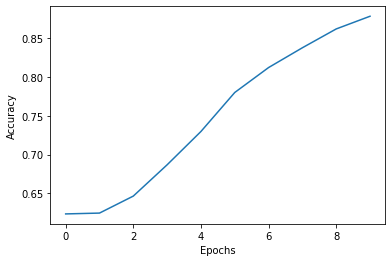

In [37]:
plt.plot(RNNmodel.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [38]:
# Naive-Bayes Classifier

index = range(len(data['clean_text']))
#data.drop('text', axis=1, inplace=True)
x_train, x_test, y_train, y_test = train_test_split(data,index,test_size=0.30,random_state=0)

train_tweets=[]
true_sentiments=[]        
word_features=[]
#stopwords = stopwords.words("english")


def get_feature_vector(tweet):
    feature_vector = []
    words = tweet.split()
    for word in words:
        #replace two or more occurences of a word with two occurrences
        repetition = re.compile(r"(.)\1{1,}", re.DOTALL)
        word = repetition.sub(r"\1\1", word)
        #check if the word begins with a letter or number
        val = re.search(r"^[a-z][a-z0-9]*$", word)
        #ignore if it is a stop word
        #if(word in stopwords or val is None):
        if(val is None):
            continue
        else:
            feature_vector.append(word)
    return feature_vector

for i in range(len(x_train)):
    sentiment = x_train['airline_sentiment'][y_train[i]]
    tweet = x_train['clean_text'][y_train[i]]
    feature_vector = get_feature_vector(tweet)
    word_features.extend(feature_vector)
    train_tweets.append((feature_vector, sentiment))

    
#print("feature vectors done")    

for i in range(len(x_test)):
    sentiment = x_test['airline_sentiment'][y_test[i]]
    true_sentiments.append((sentiment))
    
#print("true sentiments done")
                             
# Extracts each feature from the tweet and stores it in a dictionary            
def extract_features(tweet):
    words = set(tweet)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in words)
    return features
word_features = list(set(word_features))

#print("extraction done")
                             
training = nltk.classify.util.apply_features(extract_features, train_tweets)
classifier = nltk.NaiveBayesClassifier.train(training)
classifier.show_most_informative_features()
test = x_test['clean_text'].apply(lambda tweet:extract_features(get_feature_vector(tweet)))
test_sentiment = test.apply(lambda x: classifier.classify(x))



Most Informative Features
      contains(passbook) = True           positi : negati =     35.0 : 1.0
         contains(hours) = True           negati : positi =     31.0 : 1.0
          contains(rock) = True           positi : negati =     30.3 : 1.0
        contains(street) = True           neutra : negati =     28.2 : 1.0
          contains(wall) = True           neutra : negati =     27.4 : 1.0
         contains(kudos) = True           positi : negati =     27.2 : 1.0
      contains(deserves) = True           positi : negati =     27.2 : 1.0
       contains(helpful) = True           positi : neutra =     26.2 : 1.0
     contains(fantastic) = True           positi : negati =     25.6 : 1.0
     contains(wonderful) = True           positi : negati =     25.6 : 1.0


In [19]:
accuracy = 0
true_pos, true_neu, true_neg = 0,0,0
pos_accuracy, neu_accuracy, neg_accuracy = 0,0,0

for i in range(len(x_test)):
    
    if (test_sentiment[y_test[i]]==true_sentiments[i]):
        accuracy += 1
        if(test_sentiment[y_test[i]]=='positive'):
            true_pos += 1
        elif(test_sentiment[y_test[i]]=='neutral'):
            true_neu += 1
        else:
            true_neg = true_neg + 1
    
    if (true_sentiments[i]=='positive'):
        pos_accuracy += 1
    elif (true_sentiments[i]=='neutral'):
        neu_accuracy += 1
    else:
        neg_accuracy += 1         

accuracy = accuracy/float(len(x_test))
pos_accuracy = true_pos/float(pos_accuracy)
neu_accuracy = true_neu/float(neu_accuracy)
neg_accuracy = true_neg/float(neg_accuracy)

print ("Accuracy is " + str(accuracy))
print ("Positive precision is " + str(pos_accuracy))
print ("Neutral precision is " + str(neu_accuracy))
print ("Negative precision is " + str(neg_accuracy))


TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]